In [1]:
#import library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils import class_weight
import numpy as np
import zipfile, os

In [2]:
zip_path = r"D:\\KULIAH UNDIP\\SKRIPSI S NYA SANTUY\DATASET\\GuavaDiseaseDataset.zip"
extract_path = r"D:\\KULIAH UNDIP\\SKRIPSI S NYA SANTUY\\DATASET"

# Ekstrak zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [3]:
# ==========================
# 1. Parameter & Path
# ==========================
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30

base_dir = os.path.join(extract_path, "GuavaDiseaseDataset")

train_path = os.path.join(base_dir, "train")
val_path   = os.path.join(base_dir, "val")
test_path  = os.path.join(base_dir, "test")

In [4]:
# ==========================
# 2. Data Augmentation
# ==========================
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.1, 0.1),
])


In [5]:
# ==========================
# 3. Load Dataset
# ==========================
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)


Found 2647 files belonging to 3 classes.
Found 755 files belonging to 3 classes.
Found 382 files belonging to 3 classes.


In [6]:
# ==========================
# 4. EfficientNetB0 + Fine-Tuning
# ==========================
base_model = EfficientNetB0(include_top=False, input_shape=IMAGE_SIZE + (3,), weights='imagenet')
base_model.trainable = True

# Fine-tune only the last 30 layers
for layer in base_model.layers[:-30]:
    layer.trainable = False

inputs = layers.Input(shape=IMAGE_SIZE + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

In [7]:
# ==========================
# 5. Class Weights (Optional)
# ==========================
# Flatten labels for class_weight
y_train = np.concatenate([y for x, y in train_ds], axis=0)
y_labels = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_labels), y=y_labels)
class_weights = dict(enumerate(class_weights))

In [8]:
# ==========================
# 6. Compile Model
# ==========================
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [9]:
# ==========================
# 7. Callbacks
# ==========================
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_accuracy'),
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

In [10]:
# ==========================
# 8. Train
# ==========================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 51s 500ms/step - accuracy: 0.6678 - loss: 0.7560 - val_accuracy: 0.9589 - val_loss: 0.1559
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 39s 474ms/step - accuracy: 0.9490 - loss: 0.1898 - val_accuracy: 0.9854 - val_loss: 0.0554
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 39s 467ms/step - accuracy: 0.9762 - loss: 0.0928 - val_accuracy: 0.9921 - val_loss: 0.0348
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 39s 465ms/step - accuracy: 0.9793 - loss: 0.0723 - val_accuracy: 0.9947 - val_loss: 0.0311
Epoch 5/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 39s 462ms/step - accuracy: 0.9834 - loss: 0.0623 - val_accuracy: 0.9960 - val_loss: 0.0243
Epoch 6/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 39s 467ms/step - accuracy: 0.9904 - loss: 0.0325 - val_accuracy: 0.9947 - val_loss: 0.0201
Epoch 7/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 39s 465ms/step - accuracy: 0.9886 - loss: 0.0406 - val_accuracy: 0.9974 - val_loss: 0.0117
Epoch 8/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 38s 461ms/step - accuracy: 0.9894 - loss: 0.0331 - val_accu

In [11]:
# ==========================
# 9. Evaluate
# ==========================
loss, acc = model.evaluate(test_ds)
print(f"\nTest Accuracy: {acc:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 335ms/step - accuracy: 0.9991 - loss: 0.0027

Test Accuracy: 0.9974


In [12]:
# ==========================
# 10. Classification Report
# ==========================
from sklearn.metrics import classification_report
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_ds])
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 444ms/step

Classification Report:
               precision    recall  f1-score   support

  Anthracnose       1.00      1.00      1.00       156
    fruit_fly       0.99      1.00      1.00       132
healthy_guava       1.00      0.99      0.99        94

     accuracy                           1.00       382
    macro avg       1.00      1.00      1.00       382
 weighted avg       1.00      1.00      1.00       382



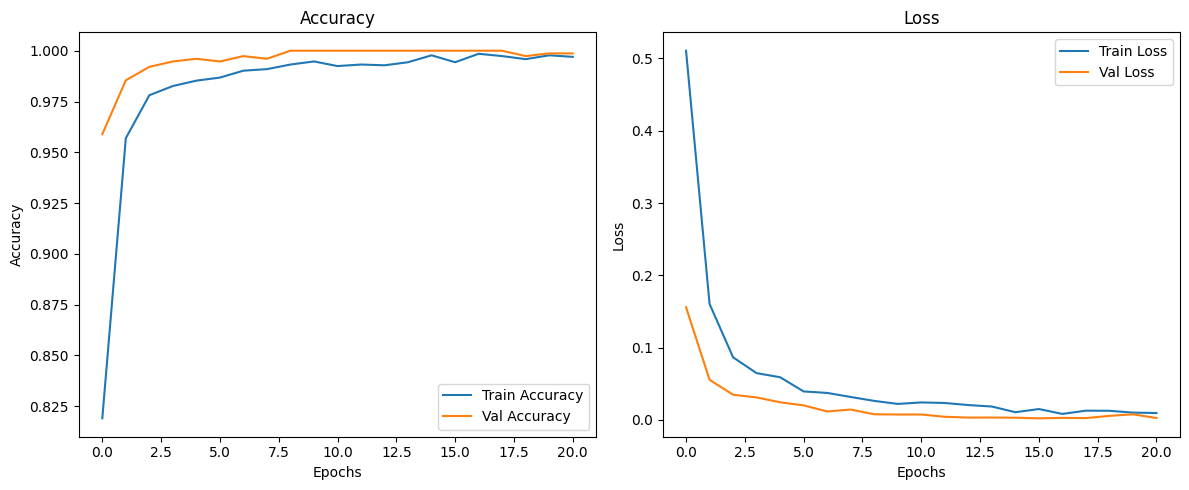

In [13]:
# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

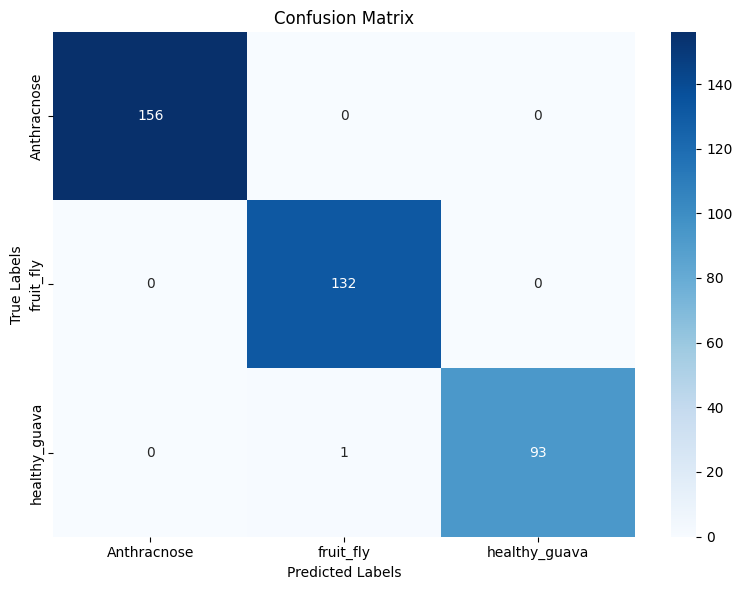

In [14]:
# True & Pred Labels (sudah ada dari sebelumnya)
# y_true = ...
# y_pred = ...

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [16]:
# Save model terbaik
model.save("best_model.keras")

# Load model terbaik dari training
model = tf.keras.models.load_model("best_model.keras")

# Konversi ke TFLite (tanpa quantization untuk memastikan tidak rusak)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan ke file
tflite_model_path = r'D:\KULIAH UNDIP\SKRIPSI S NYA SANTUY\python\GuavaDisease_CNN_Model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print("TFLite model exported to:", tflite_model_path)


INFO:tensorflow:Assets written to: C:\Users\lenovo\AppData\Local\Temp\tmpmpdikvnf\assets


INFO:tensorflow:Assets written to: C:\Users\lenovo\AppData\Local\Temp\tmpmpdikvnf\assets


Saved artifact at 'C:\Users\lenovo\AppData\Local\Temp\tmpmpdikvnf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2448086196176: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  2448086203280: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  2446840927568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2446840928144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2446840928336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2446840928912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2446840929488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2446840927184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2446840928528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2446840929296: TensorSpec(shape=(), dtype=tf.resource